!pip3 install selectivesearch

In [1]:
!pip3 install selectivesearch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 27.5 MB/s eta 0:00:000:00:0136m0:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 49.8 MB/s eta 0:00:000m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 57.7 MB/s eta 0:00:000:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.6/195.6 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 52.1 MB/s eta 0:00:00m eta 0:00:010:01
  Using cached Pillow-9.2.0-cp38-cp38-macosx_11_0_arm64.whl (2.8 MB)
  Created wheel for selectivesearch: filename=selectivesearch-0.4-py3-none-any.whl size=4336 sha256=c41c1aaa0119201104bf4f583e7dfa57d36624d584ed17f292d22b451b1bf6f9
  Stored in directory: /Users/krc/Library/Caches/pip/wheels/66/4e/88/6de23ce74be839a953498c4ebdfa809ad7da9422ac89ae856c
Successfully built selectivesearch
  Attempting uninstall: pillow
    Found existing installation: Pillow 6.2.1
    Uninstalling Pillow-6.2.1:
      S

In [4]:
!pip install xmltodict

In [5]:
import selectivesearch
import cv2
import PIL
import requests
import tensorflow as tf

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import os
import xmltodict
from copy import deepcopy

import pandas as pd
import matplotlib.patches as mpatches

# Selective search

In [6]:
def extract_candidates(img):
    img_lbl, regions = selectivesearch.selective_search(img, scale=100, min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        # excluding same rectangle (with different segments)
        if r['rect'] in candidates:
            continue
        # excluding regions smaller than 2000 pixels
        if r['size'] < (0.01*img_area):
            continue
        if r['size'] > (0.99*img_area):
            continue
        # distorted rects
        x, y, w, h = r['rect']
    #     if w / h > 1.2 or h / w > 1.2:
    #         continue
        candidates.append(list(r['rect']))
    return candidates

In [7]:
#filename = jpegs + single_object_images[ix]
url = 'https://image.dongascience.com/Photo/2020/03/15856430426741.jpg'
img = PIL.Image.open(requests.get(url, stream=True).raw)
img = tf.keras.preprocessing.image.img_to_array(img)

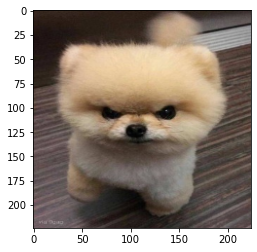

In [8]:
img = cv2.resize(img,(224,224))
img_area = img.shape[0]*img.shape[1]
candidates = extract_candidates(img)
plt.imshow(img/255)

In [9]:
candidates[:5]

[[27, 0, 55, 45],
 [58, 0, 58, 25],
 [148, 0, 75, 7],
 [93, 2, 88, 38],
 [163, 7, 60, 16]]

In [17]:
# 네모 박스 그리기
for x, y, w, h in candidates:
    img[y:(y+h), x, 1] = 1
    img[y:(y+h), (x+w), 1] = 1
    img[y, x:(x+w), 1] = 1
    img[y+h, x:(x+w), 1] = 1

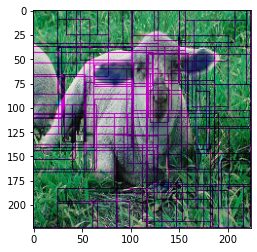

In [18]:
img = cv2.resize(img,(224,224))
img_area = img.shape[0]*img.shape[1]
candidates = extract_candidates(img)
plt.imshow(img/255)

# Read data from XML

In [19]:
xmls_root ="VOC2012_small/"  # Path to the root folder of rtaining data to be provided here
annotations = xmls_root + "Annotations/"
jpegs = xmls_root + "JPEGImages/"
XMLs = os.listdir(annotations)
print(XMLs[:10]); print(len(XMLs))

['2007_000250.xml', '2007_000241.xml', '2007_000123.xml', '2007_000042.xml', '2007_000068.xml', '2007_000121.xml', '2007_000243.xml', '2007_000032.xml', '2007_000033.xml', '2007_000027.xml']
17


# XML data

In [20]:
ix = np.random.randint(len(XMLs))
sample_xml = XMLs[ix]
sample_xml = '{}/{}'.format(annotations, sample_xml)
with open(sample_xml, "rb") as f:    # notice the "rb" mode
    d = xmltodict.parse(f, xml_attribs=True)

d

{'annotation': {'folder': 'VOC2012',
  'filename': '2007_000033.jpg',
  'source': {'database': 'The VOC2007 Database',
   'annotation': 'PASCAL VOC2007',
   'image': 'flickr'},
  'size': {'width': '500', 'height': '366', 'depth': '3'},
  'segmented': '1',
  'object': [{'name': 'aeroplane',
    'pose': 'Unspecified',
    'truncated': '0',
    'difficult': '0',
    'bndbox': {'xmin': '9', 'ymin': '107', 'xmax': '499', 'ymax': '263'}},
   {'name': 'aeroplane',
    'pose': 'Left',
    'truncated': '0',
    'difficult': '0',
    'bndbox': {'xmin': '421', 'ymin': '200', 'xmax': '482', 'ymax': '226'}},
   {'name': 'aeroplane',
    'pose': 'Left',
    'truncated': '1',
    'difficult': '0',
    'bndbox': {'xmin': '325', 'ymin': '188', 'xmax': '411', 'ymax': '223'}}]}}

In [21]:
def extract_iou2(candidate, current_y, img_shape):
    boxA = deepcopy(candidate)
    boxB = deepcopy(current_y)
    boxA[2] += boxA[0]
    boxA[3] += boxA[1]
    iou_img1 = np.zeros(img_shape)
    iou_img1[boxA[1]:boxA[3],boxA[0]:boxA[2]]=1

    iou_img2 = np.zeros(img_shape)
    iou_img2[int(boxB[1]):int(boxB[3]),int(boxB[0]):int(boxB[2])]=1
    iou = np.sum(iou_img1*iou_img2)/(np.sum(iou_img1)+np.sum(iou_img2)-np.sum(iou_img1*iou_img2))
    return iou

In [15]:
vgg16_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')

2022-07-19 10:42:51.318800: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-19 10:42:51.319185: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



# selective search vs train data

In [32]:
training_data_size = N = 17

final_cls = []
final_delta = []
iou_list = []
imgs = []

for ix, xml in enumerate(XMLs):
    
    if(ix%50==0):
        print(ix)
            
    print('Extracted data from {} xmls...'.format(ix), end='\r')
    xml_file = annotations + xml
    fname = xml.split('.')[0]
   
    with open(xml_file, "rb") as f:    # notice the "rb" mode
        xml = xmltodict.parse(f, xml_attribs=True)
        l = []
        
        if isinstance(xml["annotation"]["object"], list):
            #'let us ignore cases with multiple objects...'
            continue

        #'extracting coordinates...'
        bndbox = xml['annotation']['object']['bndbox']
        
        for key in bndbox:
            bndbox[key] = float(bndbox[key])
        x1, x2, y1, y2 = [bndbox[key] for key in ['xmin', 'xmax', 'ymin', 'ymax']]
        
        img_size = xml['annotation']['size']
        
        for key in img_size:
            img_size[key] = float(img_size[key])
        w, h = img_size['width'], img_size['height']

        #'converting pixel values from bndbox to fractions...'
        x1 /= w; x2 /= w; y1 /= h; y2 /= h
        label = xml['annotation']['object']['name']
        
        y = [x1, y1, x2-x1, y2-y1, label] # i.e., top-left x & y, width and height
        
        filename = jpegs+fname+'.jpg' # Path to the image files to be provided here
        
        img = cv2.resize(cv2.imread(filename), (224,224)) # since VGG's input shape is 224x224
        candidates = extract_candidates(img)
        
        for jx, candidate in enumerate(candidates):

            current_y2 = [int(i*224) for i in [x1,y1,x2,y2]] # [int(x1*224), int(y1*224), int(x2*224), int(y2*224)]

            iou = extract_iou2(candidate, current_y2, (224, 224))

            candidate_region_coordinates = c_x1, c_y1, c_w, c_h = np.array(candidate)/224

            dx = c_x1 - x1 
            dy = c_y1 - y1 
            dw = c_w - (x2-x1)
            dh = c_h - (y2-y1)

            final_delta.append([dx,dy,dw,dh])         

            if(iou>0.3):                    
                final_cls.append(label)
            else:
                final_cls.append('background')

            #"We'll predict our candidate crop using VGG"
            l = int(c_x1 * 224)
            r = int((c_x1 + c_w) * 224)
            t = int(c_y1 * 224)
            b = int((c_y1 + c_h) * 224)

            img2 = img[t:b,l:r,:3]
            img3 = cv2.resize(img2,(224,224))/255
            img4 = vgg16_model.predict(img3.reshape(1,224,224,3))
            imgs.append(img4[0])
            
            iou_list.append(iou)

0
1/1 [==============================] - 0s 9ms/step


KeyboardInterrupt: 

In [ ]:
imgs[0].shape

(7, 7, 512)

In [ ]:
final_delta[0]

[-0.35802469135802467, -0.202, 0.03277483833039385, -0.18749999999999994]

In [ ]:
final_cls[0]

'background'

In [ ]:
final_cls

['background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'person',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'person',
 'background',
 'background',
 'background',
 'person',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'person',
 'background',
 'background',
 'backgroun

In [33]:
targets = pd.DataFrame(final_cls, columns=['label'])
print(targets.head())
labels = pd.get_dummies(targets['label']).columns
print(labels[:5])
y_train = pd.get_dummies(targets['label']).values.astype(float)
print(y_train[:5])

        label
0       train
1  background
2  background
3  background
4  background
Index(['background', 'train'], dtype='object')
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [34]:
x_train = np.array(imgs)
x_train.shape

(116, 7, 7, 512)

In [35]:
img3.shape

(224, 224, 3)

In [36]:
res = vgg16_model.predict(img3.reshape(1,224,224,3))

1/1 [==============================] - 0s 10ms/step


In [37]:
res.shape

(1, 7, 7, 512)

In [38]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,UpSampling2D, Dropout, Cropping2D,  concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

model = Sequential()
model.add(Flatten(input_shape=((7,7,512))))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1],activation='softmax'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_4 (Dropout)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 12,846,594
Trainable params: 12,846,594
Non-trainable params: 0
_________________________________________________________________


In [39]:
y_train.shape

(117, 2)

In [40]:
history = model.fit(x_train/x_train.max(), y_train, validation_split = 0.1, epochs=10, batch_size=64, verbose=1)

Epoch 1/10


2022-07-19 11:01:32.469603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 162ms/step - loss: 0.6148 - accuracy: 0.5673 - val_loss: 2.0481 - val_accuracy: 0.3333
Epoch 2/10
2/2 [==============================] - 0s 41ms/step - loss: 0.4341 - accuracy: 0.8558 - val_loss: 1.4977 - val_accuracy: 0.3333
Epoch 3/10
2/2 [==============================] - 0s 38ms/step - loss: 0.3266 - accuracy: 0.8558 - val_loss: 0.9836 - val_accuracy: 0.3333
Epoch 4/10
1/2 [==============>...............] - ETA: 0s - loss: 0.2434 - accuracy: 0.8750

2022-07-19 11:01:32.852847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 41ms/step - loss: 0.2643 - accuracy: 0.8558 - val_loss: 0.7509 - val_accuracy: 0.3333
Epoch 5/10
2/2 [==============================] - 0s 41ms/step - loss: 0.2336 - accuracy: 0.8654 - val_loss: 0.6338 - val_accuracy: 0.3333
Epoch 6/10
2/2 [==============================] - 0s 41ms/step - loss: 0.1909 - accuracy: 0.9135 - val_loss: 0.5845 - val_accuracy: 0.4167
Epoch 7/10
2/2 [==============================] - 0s 41ms/step - loss: 0.1503 - accuracy: 0.9423 - val_loss: 0.5767 - val_accuracy: 0.4167
Epoch 8/10
2/2 [==============================] - 0s 39ms/step - loss: 0.1411 - accuracy: 0.9327 - val_loss: 0.5021 - val_accuracy: 0.4167
Epoch 9/10
2/2 [==============================] - 0s 36ms/step - loss: 0.1248 - accuracy: 0.9519 - val_loss: 0.4089 - val_accuracy: 1.0000
Epoch 10/10
2/2 [==============================] - 0s 42ms/step - loss: 0.0971 - accuracy: 0.9712 - val_loss: 0.3355 - val_accuracy: 1.0000


In [41]:
def test_predictions(filename):
    img = cv2.resize(cv2.imread(filename), (224,224))
    candidates = extract_candidates(img)

    _, ax = plt.subplots(1, 2)

    ax[0].imshow(img)
    ax[0].grid('off')
    ax[0].set_title(filename.split('/')[-1])


    pred = []
    pred_class = []

    for ix, candidate in enumerate(candidates):

        l, t, w, h = np.array(candidate).astype(int)

        img2 = img[t:t+h,l:l+w,:3]
        img3 = cv2.resize(img2,(224,224))/255
        img4 = vgg16_model.predict(img3.reshape(1,224,224,3))
        final_pred = model.predict(img4/x_train.max())
        pred.append(np.max(final_pred))
        pred_class.append(np.argmax(final_pred))

    pred = np.array(pred)
    pred_class = np.array(pred_class)

    pred2 = pred[pred_class!=1]
    pred_class2 = pred_class[pred_class!=1]

    candidates2 = np.array(candidates)[pred_class!=1]

    x, y, w, h = candidates2[np.argmax(pred2)]

    ax[1].set_title(labels[pred_class2[np.argmax(pred2)]])
    ax[1].imshow(img)
    ax[1].grid('off')
    rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='blue', linewidth=3)
    ax[1].add_patch(rect)

In [42]:
filename = jpegs + XMLs[0].replace('xml', 'jpg')
filename

'VOC2012_small/JPEGImages/2007_000250.jpg'

1/1 [==============================] - 0s 8ms/step


2022-07-19 11:01:35.856268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 9ms/step


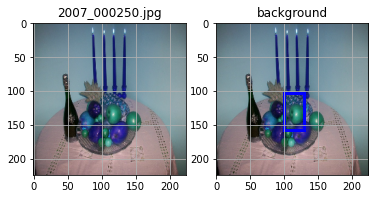

In [43]:
test_predictions(filename)